In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F
from timeit import default_timer as timer
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))
        
'''image_directory='/kaggle/input/brain-tumor-mri-dataset/'
glioma_tumor_train=os.listdir(image_directory+ 'Training/glioma/')
meningioma_tumor_train=os.listdir(image_directory+ 'Training/meningioma/')
no_tumor_train=os.listdir(image_directory+ 'Training/notumor/')
pituitary_tumor_train=os.listdir(image_directory+ 'Training/pituitary/')

glioma_tumor_test=os.listdir(image_directory+ 'Testing/glioma/')
meningioma_tumor_test=os.listdir(image_directory+ 'Testing/meningioma/')
no_tumor_test=os.listdir(image_directory+ 'Testing/notumor/')
pituitary_tumor_test=os.listdir(image_directory+ 'Testing/pituitary/')
print('Glioma Tumor: ', len(glioma_tumor_train))
print('meningioma Tumor: ', len(meningioma_tumor_train))
print('No Tumor: ', len(no_tumor_train))
print('Pituitary Tumor: ', len(pituitary_tumor_train))

print('Glioma Tumor: ', len(glioma_tumor_test))
print('meningioma Tumor: ', len(meningioma_tumor_test))
print('No Tumor: ', len(no_tumor_test))
print('Pituitary Tumor: ', len(pituitary_tumor_test))

#print('Tumor: ',len(yes_tumor_images))

dataset=[]
label=[]

INPUT_SIZE=64
for i , image_name in enumerate(glioma_tumor_train):
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(image_directory+'Training/glioma/'+image_name)
        image=Image.fromarray(image,'RGB')
        image=image.resize((INPUT_SIZE,INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(2)
for i , image_name in enumerate(meningioma_tumor_train):
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(image_directory+'Training/meningioma/'+image_name)
        image=Image.fromarray(image, 'RGB')
        image=image.resize((INPUT_SIZE,INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(1)
for i , image_name in enumerate(no_tumor_train):
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(image_directory+'Training/notumor/'+image_name)
        image=Image.fromarray(image, 'RGB')
        image=image.resize((INPUT_SIZE,INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(0)
for i , image_name in enumerate(pituitary_tumor_train):
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(image_directory+'Training/pituitary/'+image_name)
        image=Image.fromarray(image, 'RGB')
        image=image.resize((INPUT_SIZE,INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(3)
dataset=np.array(dataset)
label=np.array(label)

print('Dataset: ',len(dataset))
print('Label: ',len(label))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
'''


'image_directory=\'/kaggle/input/brain-tumor-mri-dataset/\'\nglioma_tumor_train=os.listdir(image_directory+ \'Training/glioma/\')\nmeningioma_tumor_train=os.listdir(image_directory+ \'Training/meningioma/\')\nno_tumor_train=os.listdir(image_directory+ \'Training/notumor/\')\npituitary_tumor_train=os.listdir(image_directory+ \'Training/pituitary/\')\n\nglioma_tumor_test=os.listdir(image_directory+ \'Testing/glioma/\')\nmeningioma_tumor_test=os.listdir(image_directory+ \'Testing/meningioma/\')\nno_tumor_test=os.listdir(image_directory+ \'Testing/notumor/\')\npituitary_tumor_test=os.listdir(image_directory+ \'Testing/pituitary/\')\nprint(\'Glioma Tumor: \', len(glioma_tumor_train))\nprint(\'meningioma Tumor: \', len(meningioma_tumor_train))\nprint(\'No Tumor: \', len(no_tumor_train))\nprint(\'Pituitary Tumor: \', len(pituitary_tumor_train))\n\nprint(\'Glioma Tumor: \', len(glioma_tumor_test))\nprint(\'meningioma Tumor: \', len(meningioma_tumor_test))\nprint(\'No Tumor: \', len(no_tumor_te

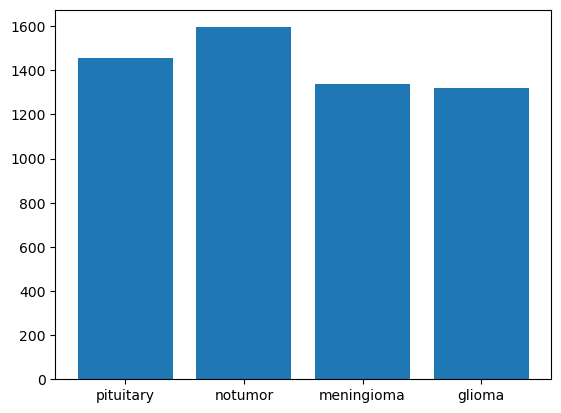

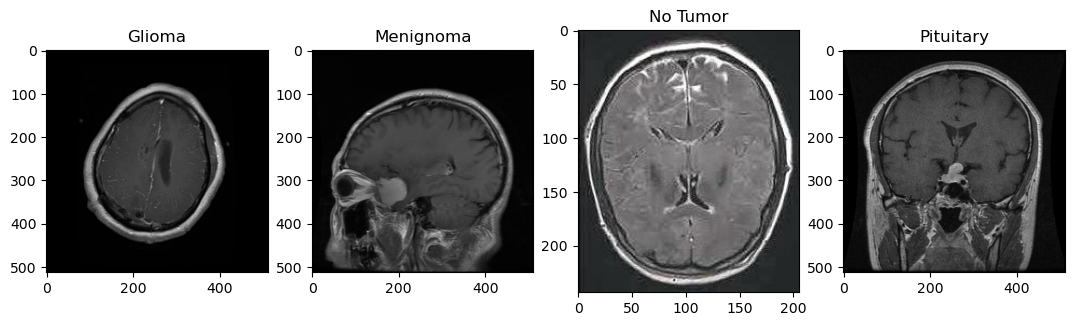

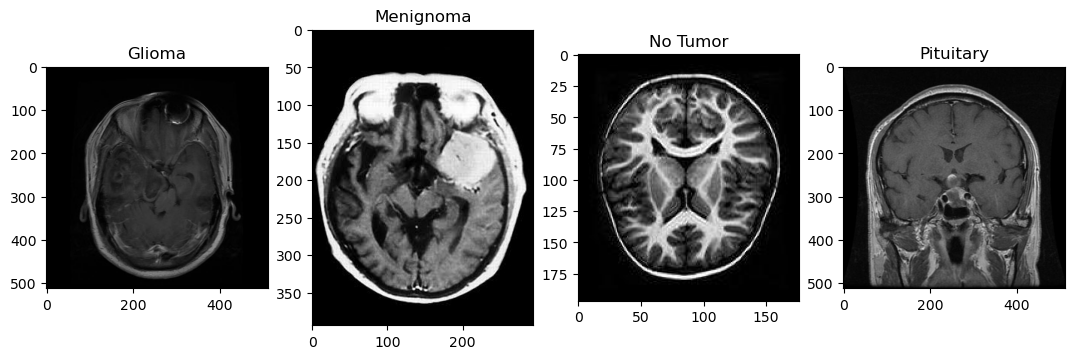

training data sizes :  [1079, 1178, 991, 974]
validation data sizes :  [437, 478, 401, 396]
Total Number of training images :  4222
Total Number of validation images :  1712


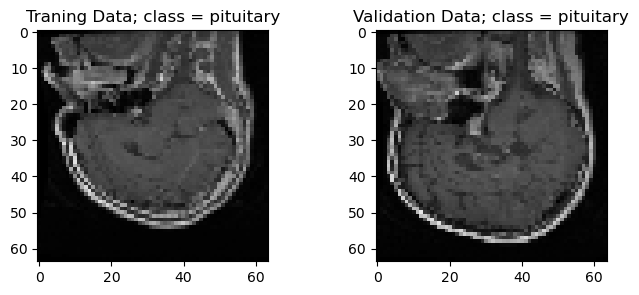

using device: cpu


In [3]:
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
def data_count(main_path = '../input/brain-tumor-mri-dataset/Training'):
    counts = {}
    for root,dirs,files in os.walk(main_path):
        if files != [] and str(root.split('/')[-1]) in classes:
            counts[str(root.split('/')[-1])] = len(files)
    return counts
counts = data_count()
plt.bar(list(counts.keys()),list(counts.values()))
plt.show()
def data_split(main_path = '../input/brain-tumor-mri-dataset/Training', split_percentage = 0.3):
    train_dict = {}
    valid_dict = {}
    counts = data_count(main_path)
    for root,dirs,files in os.walk(main_path):
        if files != [] and str(root.split('/')[-1]) in ['glioma', 'meningioma', 'notumor', 'pituitary']:
            file_paths = [os.path.join(root,files[i]) for i in range(len(files))]
            
            valid_idxs = np.random.randint(low=0,high=len(files),size=int(len(files)*split_percentage))
            train_idxs = list(set(range(0,len(files))) - set(valid_idxs))
            
            train_dict[str(root.split('/')[-1])] = [file_paths[idx] for idx in train_idxs]
            valid_dict[str(root.split('/')[-1])] = [file_paths[idx] for idx in valid_idxs]
            
    return train_dict, valid_dict
train_dict, valid_dict = data_split()

def visualize(data_dict):    
    idx = np.random.randint(0,min(list([len(l) for l in data_dict.values()])))

    plt.figure(figsize=(20,6))
    plt.subplot(161)
    plt.imshow(cv2.imread(train_dict['glioma'][idx]).astype(int))
    plt.title('Glioma')
    plt.subplot(162)
    plt.imshow(cv2.imread(train_dict['meningioma'][idx]).astype(int))
    plt.title('Menignoma')
    plt.subplot(163)
    plt.imshow(cv2.imread(train_dict['notumor'][idx]).astype(int))
    plt.title('No Tumor')
    plt.subplot(164)
    plt.imshow(cv2.imread(train_dict['pituitary'][idx]).astype(int))
    plt.title('Pituitary')

    plt.show()
train_dict.keys()
visualize(train_dict)
visualize(valid_dict)
print('training data sizes : ', [len(l) for l in train_dict.values()])
print('validation data sizes : ', [len(l) for l in valid_dict.values()])
class MRIData(Dataset):
    """Chess Piece Dataset class"""
    
    def __init__(self, data_dict, transform=None):
        """
        Args:
            data_dict (dict): dictionary with class as key and the corresponding paths to the data of that class 
        """
        self.data_dict = data_dict
        self.transform = transform
        
    def __len__(self):
        return sum([len(l) for l in self.data_dict.values()])
    
    def __getitem__(self,idx):
        counts = [len(l) for l in self.data_dict.values()]
        sum_counts = list(np.cumsum(counts))
        sum_counts = [0] + sum_counts + [np.inf]
        
        for c,v in enumerate(sum_counts):
            if idx < v:
                i = (idx - sum_counts[c-1]) - 1
                break
        #print(c,i,idx)
        label = list(self.data_dict.keys())[c-1]
        img = Image.open(self.data_dict[str(label)][i]).convert('RGB')
        if self.transform:
            img = self.transform(img)
            
        return img, classes.index(str(label))
data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.RandomAdjustSharpness(sharpness_factor=1.5),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ColorJitter(),
                                     transforms.Resize((64,64))])

data_train = MRIData(train_dict,transform = data_transform)
data_valid = MRIData(valid_dict,transform = data_transform)
t_idx = np.random.randint(0,len(data_train))
v_idx = np.random.randint(0,len(data_valid))

print("Total Number of training images : ", len(data_train))
print("Total Number of validation images : ", len(data_valid))

t_img,t_label = data_train[t_idx]
v_img,v_label = data_valid[v_idx]

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.imshow(t_img.numpy().transpose(1,2,0))
plt.title(f'Traning Data; class = {classes[t_label]}')
plt.subplot(122)
plt.imshow(v_img.numpy().transpose(1,2,0))
plt.title(f'Validation Data; class = {classes[v_label]}')
plt.show()

USE_GPU = True
num_class = 100
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

In [5]:
train_loader = DataLoader(data_train, batch_size=50, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=50, shuffle=True)

In [6]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            if t % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                check_accuracy_part34(valid_loader, model)
                #iter_list.append(t)
                print()


In [6]:
class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()
      
        self.conv_1 = nn.Conv2d(in_channel, channel_1, (5,5), padding=2)
        nn.init.kaiming_normal_(self.conv_1.weight)
        self.conv_2 = nn.Conv2d(channel_1, channel_2, (3,3), padding=1)
        nn.init.kaiming_normal_(self.conv_2.weight)

        self.fc1 = nn.Linear(262144, 4)
        self.relu = nn.ReLU(inplace=True)
        


    def forward(self,x):
        scores = None
        ########################################################################
        # TODO: Implement the forward function for a 3-layer ConvNet. you      #
        # should use the layers you defined in __init__ and specify the        #
        # connectivity of those layers in forward()                            #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        x = self.relu(self.conv_2(self.relu((self.conv_1(x)))))
        x = flatten(x)
        scores = self.fc1(x)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return scores
class ThirteenLayerConvnet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()
      
        self.conv_1 = nn.Conv2d(in_channel, channel_1, (5,5))
        nn.init.kaiming_normal_(self.conv_1.weight)
        self.conv_2 = nn.Conv2d(channel_1, channel_2, (5,5), padding=1)
        nn.init.kaiming_normal_(self.conv_2.weight)
        self.batchnorm = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(3)
        self.dropout = nn.Dropout2d(.3)
        self.fc1 = nn.Linear(2304, 4)
        self.relu = nn.ReLU(inplace=True)
        self.softmax = nn.Softmax()
        

    def forward(self,x):
        scores = None
        ########################################################################
        # TODO: Implement the forward function for a 3-layer ConvNet. you      #
        # should use the layers you defined in __init__ and specify the        #
        # connectivity of those layers in forward()                            #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.batchnorm(x)
        x = self.maxpool(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.batchnorm2(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        x = flatten(x)
        x = self.fc1(x)
        scores = self.softmax(x)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return scores


In [7]:
def check_accuracy_part34(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        #acc_list.append(acc)
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [ ]:
learning_rate = 1e-3
channel_1 = 32
channel_2 = 64
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
model = None
optimizer = None
################################################################################
# TODO: Instantiate your ThreeLayerConvNet model and a corresponding optimizer #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
model = ThirteenLayerConvnet(3,channel_1,channel_2,num_class)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

train_part34(model, optimizer, epochs=10)

In [ ]:
learning_rate = 1e-3
channel_1 = 32
channel_2 = 64
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
model = None
optimizer = None
################################################################################
# TODO: Instantiate your ThreeLayerConvNet model and a corresponding optimizer #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
model = ThreeLayerConvNet(3,channel_1,channel_2,num_class)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

train_part34(model, optimizer, epochs=10)

In [12]:
learning_rate = 1e-3
channel_1 = 32
channel_2 = 64
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
model = None
optimizer = None
################################################################################
# TODO: Instantiate your ThreeLayerConvNet model and a corresponding optimizer #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
model = ThreeLayerConvNet(3,channel_1,channel_2,num_class)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

train_part34(model, optimizer, epochs=10)

Epoch 0, Iteration 0, loss = 1.3905
Got 495 / 1712 correct (28.91)

Epoch 1, Iteration 0, loss = 0.6287
Got 1254 / 1712 correct (73.25)

Epoch 2, Iteration 0, loss = 0.2833
Got 1484 / 1712 correct (86.68)

Epoch 3, Iteration 0, loss = 0.2775
Got 1470 / 1712 correct (85.86)

Epoch 4, Iteration 0, loss = 0.2137
Got 1512 / 1712 correct (88.32)

Epoch 5, Iteration 0, loss = 0.0889
Got 1535 / 1712 correct (89.66)

Epoch 6, Iteration 0, loss = 0.0534
Got 1574 / 1712 correct (91.94)

Epoch 7, Iteration 0, loss = 0.1034
Got 1578 / 1712 correct (92.17)

Epoch 8, Iteration 0, loss = 0.1023
Got 1569 / 1712 correct (91.65)

Epoch 9, Iteration 0, loss = 0.0412
Got 1591 / 1712 correct (92.93)



In [10]:
class ThreeLayerConvNet2(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()
      
        self.conv_1 = nn.Conv2d(in_channel, channel_1, (5,5), padding=2)
        nn.init.kaiming_normal_(self.conv_1.weight)
        self.batch = nn.BatchNorm2d(channel_1)
        self.conv_2 = nn.Conv2d(channel_1, channel_2, (3,3), padding=1)
        nn.init.kaiming_normal_(self.conv_2.weight)
        self.batch2 = nn.BatchNorm2d(channel_2)

        self.fc1 = nn.Linear(262144, 262144)
        self.fc2 = nn.Linear(262144, 4)
        self.relu = nn.ReLU(inplace=True)
        


    def forward(self,x):
        scores = None
        ########################################################################
        # TODO: Implement the forward function for a 3-layer ConvNet. you      #
        # should use the layers you defined in __init__ and specify the        #
        # connectivity of those layers in forward()                            #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.batch(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.batch2(x)
        x = flatten(x)
        x = self.fc1(x)
        scores = self.fc2(x)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return scores

In [13]:
learning_rate = 1e-3
channel_1 = 32
channel_2 = 64
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
model = None
optimizer = None
################################################################################
# TODO: Instantiate your ThreeLayerConvNet model and a corresponding optimizer #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
model = ThreeLayerConvNet2(3,channel_1,channel_2,num_class)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

train_part34(model, optimizer, epochs=10)

Epoch 0, Iteration 0, loss = 1.3091
Got 478 / 1712 correct (27.92)

Epoch 1, Iteration 0, loss = 7.4457
Got 1329 / 1712 correct (77.63)

Epoch 2, Iteration 0, loss = 2.9090
Got 1436 / 1712 correct (83.88)

Epoch 3, Iteration 0, loss = 5.2029
Got 1457 / 1712 correct (85.11)

Epoch 4, Iteration 0, loss = 2.5368
Got 1508 / 1712 correct (88.08)

Epoch 5, Iteration 0, loss = 2.3105
Got 1511 / 1712 correct (88.26)

Epoch 6, Iteration 0, loss = 0.1131
Got 1533 / 1712 correct (89.54)

Epoch 7, Iteration 0, loss = 1.4992
Got 1532 / 1712 correct (89.49)

Epoch 8, Iteration 0, loss = 0.0117
Got 1564 / 1712 correct (91.36)

Epoch 9, Iteration 0, loss = 0.7380
Got 1547 / 1712 correct (90.36)



In [14]:
learning_rate = 1e-3
channel_1 = 32
channel_2 = 64
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
model = None
optimizer = None
################################################################################
# TODO: Instantiate your ThreeLayerConvNet model and a corresponding optimizer #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
model = ThreeLayerConvNet2(3,channel_1,channel_2,num_class)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

train_part34(model, optimizer, epochs=10)

Epoch 0, Iteration 0, loss = 1.5291
Got 586 / 1712 correct (34.23)

Epoch 1, Iteration 0, loss = 1.0709
Got 1116 / 1712 correct (65.19)

Epoch 2, Iteration 0, loss = 0.9884
Got 1335 / 1712 correct (77.98)

Epoch 3, Iteration 0, loss = 0.3866
Got 1439 / 1712 correct (84.05)

Epoch 4, Iteration 0, loss = 0.6162
Got 1433 / 1712 correct (83.70)

Epoch 5, Iteration 0, loss = 0.4604
Got 1490 / 1712 correct (87.03)

Epoch 6, Iteration 0, loss = 0.1108
Got 1536 / 1712 correct (89.72)

Epoch 7, Iteration 0, loss = 0.0771
Got 1558 / 1712 correct (91.00)

Epoch 8, Iteration 0, loss = 0.1606
Got 1568 / 1712 correct (91.59)

Epoch 9, Iteration 0, loss = 0.0789
Got 1576 / 1712 correct (92.06)



In [15]:
class ThreeLayerConvNetSGD(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()
      
        self.conv_1 = nn.Conv2d(in_channel, channel_1, (5,5), padding=2)
        nn.init.kaiming_normal_(self.conv_1.weight)
        self.batch = nn.BatchNorm2d(channel_1)
        self.conv_2 = nn.Conv2d(channel_1, channel_2, (3,3), padding=1)
        self.conv_3 = nn.Conv2d(channel_2,channel_2,(3,3))
        nn.init.kaiming_normal_(self.conv_2.weight)
        self.batch2 = nn.BatchNorm2d(channel_2)

        self.fc1 = nn.Linear(262144, 4)
        self.relu = nn.ReLU(inplace=True)
        


    def forward(self,x):
        scores = None
        ########################################################################
        # TODO: Implement the forward function for a 3-layer ConvNet. you      #
        # should use the layers you defined in __init__ and specify the        #
        # connectivity of those layers in forward()                            #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.batch(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.batch2(x)
        x = flatten(x)
        scores = self.fc1(x)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return scores

In [17]:
learning_rate = 1e-3
channel_1 = 32
channel_2 = 64
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
model = None
optimizer = None
################################################################################
# TODO: Instantiate your ThreeLayerConvNet model and a corresponding optimizer #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
model = ThreeLayerConvNetSGD(3,channel_1,channel_2,num_class)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

train_part34(model, optimizer, epochs=10)

Epoch 0, Iteration 0, loss = 1.6319
Got 478 / 1712 correct (27.92)

Epoch 1, Iteration 0, loss = 0.5923
Got 1322 / 1712 correct (77.22)

Epoch 2, Iteration 0, loss = 0.3210
Got 1439 / 1712 correct (84.05)

Epoch 3, Iteration 0, loss = 0.3097
Got 1474 / 1712 correct (86.10)

Epoch 4, Iteration 0, loss = 0.0805
Got 1518 / 1712 correct (88.67)

Epoch 5, Iteration 0, loss = 0.1659
Got 1506 / 1712 correct (87.97)

Epoch 6, Iteration 0, loss = 0.3391
Got 1522 / 1712 correct (88.90)

Epoch 7, Iteration 0, loss = 0.1571
Got 1547 / 1712 correct (90.36)

Epoch 8, Iteration 0, loss = 0.1093
Got 1556 / 1712 correct (90.89)

Epoch 9, Iteration 0, loss = 0.0440
Got 1565 / 1712 correct (91.41)



In [9]:
class ThreeLayerConvNetAdamExtraLayer(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()
      
        self.conv_1 = nn.Conv2d(in_channel, channel_1, (5,5), padding=2)
        nn.init.kaiming_normal_(self.conv_1.weight)
        self.batch = nn.BatchNorm2d(channel_1)
        self.conv_2 = nn.Conv2d(channel_1, channel_2, (3,3), padding=1)
        self.conv_3 = nn.Conv2d(channel_2,channel_2,(3,3))
        nn.init.kaiming_normal_(self.conv_2.weight)
        self.batch2 = nn.BatchNorm2d(channel_2)
        self.batch3 = nn.BatchNorm2d(channel_2)
        self.fc1 = nn.Linear(262144, 262144)
        self.fc2 = nn.Linear(262144, 4)
        self.relu = nn.ReLU(inplace=True)
        


    def forward(self,x):
        scores = None
        ########################################################################
        # TODO: Implement the forward function for a 3-layer ConvNet. you      #
        # should use the layers you defined in __init__ and specify the        #
        # connectivity of those layers in forward()                            #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.batch(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.batch2(x)
        x = self.conv_3(x)
        x = self.relu(x)
        x = self.batch3(x)
        x = flatten(x)
        x = self.fc2(x)
        scores = x
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return scores
    

In [ ]:
learning_rate = 1e-3
channel_1 = 32
channel_2 = 64
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
model = None
optimizer = None
################################################################################
# TODO: Instantiate your ThreeLayerConvNet model and a corresponding optimizer #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
model = ThreeLayerConvNetAdamExtraLayer(3,channel_1,channel_2,num_class)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

train_part34(model, optimizer, epochs=10)